In [1]:
#Data loading and Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
    
IMG_SIZE = 128  
    
def load_images(data_dir):
        
        images = []
        labels = []
        
        for class_name in sorted(os.listdir(data_dir)):
            class_path = os.path.join(data_dir, class_name)
            
            # Check if it's a directory
            if os.path.isdir(class_path):
                # Collect all .jpg and .jpeg files
                img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]
                
                for img_file in img_files:
                    img_path = os.path.join(class_path, img_file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append((img, class_name))  # Store image and class name
                    else:
                        print(f"Warning: Unable to load image {img_path}")
    
        return images
    
def remove_null_classes(images):
        """Removes null classes (classes with no images)."""
        
        filtered_images = [(img, label) for img, label in images if label]
        return filtered_images
    
def remove_outlier_classes(images, min_images=5):
        """Removes classes with fewer than or equal to min_images."""
        from collections import Counter
        class_counts = Counter([label for _, label in images])
        
       
        filtered_images = [(img, label) for img, label in images if class_counts[label] > min_images]
        
        for class_name, count in class_counts.items():
            if count <= min_images:
                print(f"Skipping '{class_name}' - too few images ({count} found)")
    
        return filtered_images
    
def resize_images(images):
        """Resizes images to the specified size (IMG_SIZE) and normalizes pixel values."""
        resized_images = []
        
        for img, label in images:
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to target size
            img_normalized = img_resized / 255.0  # Normalize pixel values
            resized_images.append((img_normalized, label))
    
        return resized_images
    
    
def encode_labels(images):
        """Encodes labels into numerical values and reduces memory usage."""
        labels = [label for _, label in images]
        
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        encoded_class_names = label_encoder.classes_
        
        print("Class names with their encoded values:")
        for index, class_name in enumerate(encoded_class_names):
            print(f"{class_name}: {index}")
        
        # Convert images to float32 for reduced memory usage
        encoded_images = [(img.astype(np.float32), encoded_label) for (img, _), encoded_label in zip(images, encoded_labels)]
        
       
        image_array = np.array([img for img, _ in encoded_images])
        label_array = np.array([label for _, label in encoded_images])
        
        return image_array, label_array, encoded_class_names
    
    
def preprocess_images(data_dir):
        """Main function to load, preprocess, and encode images and labels."""
        # Step 1: Load data
        images = load_images(data_dir)
        
        # Step 2: Remove null classes
        images = remove_null_classes(images)
        
        # Step 3: Remove outlier classes
        images = remove_outlier_classes(images)
        
        # Step 4: Resize and normalize images
        images = resize_images(images)
        
        # Step 5: Encode labels
        images, labels, class_names = encode_labels(images)
        
        print(f"Loaded {len(images)} images from {len(class_names)} valid classes.")
        
        return images, labels, class_names
    
    
DATA_DIR = r"D:\ML Project\Dataset" 
images, labels, class_names = preprocess_images(DATA_DIR)
    


Skipping 'Tick' - too few images (1 found)
Class names with their encoded values:
Bear: 0
Butterfly: 1
Cat: 2
Cheetah: 3
Crocodile: 4
Dog: 5
Elephant: 6
Frog: 7
Horse: 8
Leopard: 9
Lion: 10
Lizard: 11
Monkey: 12
Parrot: 13
Rabbit: 14
Shark: 15
Sheep: 16
Snake: 17
Spider: 18
Squirrel: 19
Tiger: 20
Tortoise: 21
Whale: 22
Zebra: 23
Loaded 2508 images from 24 valid classes.


In [3]:
import numpy as np

# Save the images and labels as NumPy arrays
np.save(r"D:\ML Project\images.npy", images)
np.save(r"D:\ML Project\labels.npy", labels)
np.save(r"D:\ML Project\class_names.npy", class_names)
print("Preprocessed data is saved")


Preprocessed data is saved


In [5]:
# Load the images, labels, and class names
import numpy as np
images = np.load(r"D:\ML Project\images.npy")
labels = np.load(r"D:\ML Project\labels.npy")
class_names = np.load(r"D:\ML Project\class_names.npy")
print("Preprocessed data is loaded")


Preprocessed data is loaded


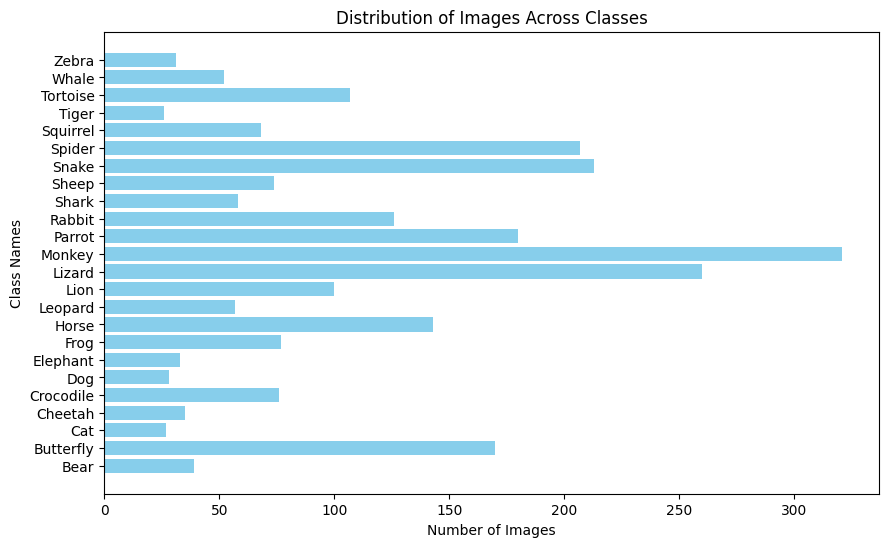

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(labels, class_names):
    """Plots the distribution of images across classes."""
    # Count the number of images per class (based on labels)
    class_counts = Counter(labels)
    
    # Get the class names and their respective counts
    class_names_list = [class_names[label] for label in class_counts.keys()]
    counts = list(class_counts.values())
    
    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    plt.barh(class_names_list, counts, color='skyblue')
    plt.xlabel('Number of Images')
    plt.ylabel('Class Names')
    plt.title('Distribution of Images Across Classes')
    plt.show()

# Example usage:
plot_class_distribution(labels, class_names)


In [9]:
# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)
# Calculate total number of images in train and test sets
total_train_images = len(train_images)
total_test_images = len(test_images)
print("Images in train set: ", total_train_images)
print("Images in test set: ", total_test_images)

Images in train set:  2006
Images in test set:  502


In [11]:
#Model Creation
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import numpy as np

IMG_SIZE = 128  

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(train_images)

# Load the MobileNetV2 model pre-trained on ImageNet and exclude the top layer
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Unfreeze the base model layers for fine-tuning

# Freeze all but the last 20 layers for fine-tuning
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax', kernel_regularizer=regularizers.l2(0.01))  # L2 regularization
])

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Train the model with data augmentation and callbacks
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stop]
)

# Print the final training and validation (test) accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/50


C:\Users\kesha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 337ms/step - accuracy: 0.1238 - loss: 6.5649 - val_accuracy: 0.4661 - val_loss: 4.6833 - learning_rate: 1.0000e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.4440 - loss: 4.6857 - val_accuracy: 0.6554 - val_loss: 3.9708 - learning_rate: 1.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.6051 - loss: 4.0384 - val_accuracy: 0.7271 - val_loss: 3.6852 - learning_rate: 1.0000e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - accuracy: 0.6796 - loss: 3.7686 - val_accuracy: 0.7470 - val_loss: 3.5079 - learning_rate: 1.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - accuracy: 0.7306 - loss: 3.5615 - val_accuracy: 0.7629 - val_loss: 3.3756 - learning_rate: 1.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.7624 - loss: 3.3931 - val_accuracy: 0.7649 - val_loss: 3.3056 - learning_rate: 1.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.76

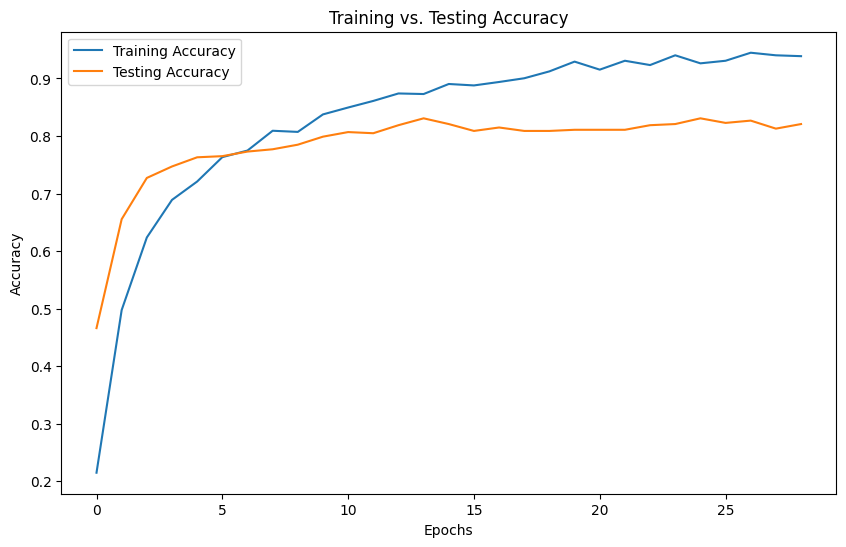

In [13]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    """Plots the training and validation accuracy over epochs."""
    epochs = range(len(history.history['accuracy']))
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

# Example usage:
plot_accuracy(history)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step


<Figure size 1000x800 with 0 Axes>

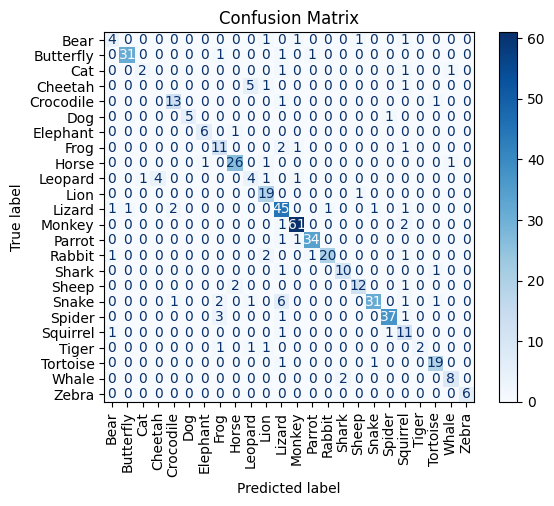

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_images, test_labels, class_names):
    """Plots the confusion matrix for the given model and test data."""
    # Predict the classes
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, predicted_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(model, test_images, test_labels, class_names)


In [17]:
# Save the entire model
model.save(r"D:\ML Project.keras")
print("Model is saved")


Model is saved


In [19]:
# To load the model later
from tensorflow.keras.models import load_model
loaded_model = load_model(r"D:\ML Project.keras")
print("Model is loaded")

Model is loaded


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


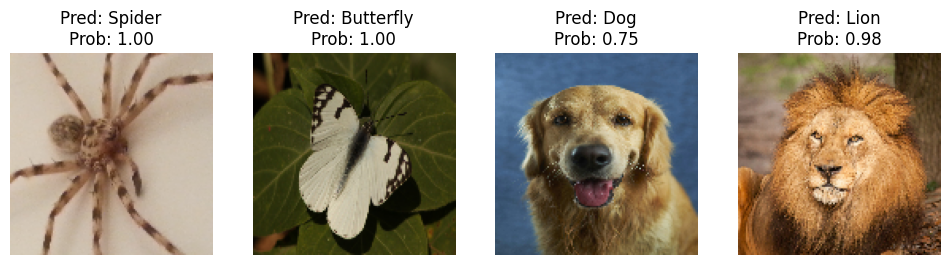

In [21]:
# Model Evaluation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_classes(model, img_paths, class_names, img_size=128):
    """Predict the class of images and return predictions, probabilities, and images."""
    predictions = []
    probabilities = []
    images = []
    
    for img_path in img_paths:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(img_size, img_size))  # Resize to target size
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize to [0, 1]
        
        # Predict the class probabilities
        pred = model.predict(img_array)
        
        # Get the predicted class index and probability
        pred_class_index = np.argmax(pred, axis=1)[0]
        pred_probability = np.max(pred)
        
        # Convert the class index to the class name
        predicted_class = class_names[pred_class_index]
        
        predictions.append(predicted_class)
        probabilities.append(pred_probability)
        images.append(img)
    
    return predictions, probabilities, images

def display_predictions(img_paths, predictions, probabilities, images):
    """Display the images with their predicted class and probability."""
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {predictions[i]}\nProb: {probabilities[i]:.2f}")
    plt.show()

# Example usage
img_paths = [
    r"D:\ML Project\Dataset\Spider\4f18c7010cc3f63a.jpg",
    r"D:\ML Project\Dataset\Butterfly\0ba8dea9487e3833.jpg",
    r"D:\ML Project\Dataset\Dog\photo-1558788353-f76d92427f16.jpeg",
    r"D:\ML Project\Dataset\Lion\0149d723dbc0d724.jpg"
]

# Assuming `model` and `class_names` are already defined
predictions, probabilities, images = predict_classes(loaded_model, img_paths, class_names)
display_predictions(img_paths, predictions, probabilities, images)


In [13]:
import keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load VGG19 pretrained model with ImageNet weights
pretrained_model = VGG19(
    weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False
)

# Freeze all layers, except the last block (block5_conv1 onwards)
pretrained_model.trainable = True
set_trainable = False

for layer in pretrained_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

# Add custom layers on top of the base model
model_vgg19 = keras.models.Sequential()
model_vgg19.add(pretrained_model)
model_vgg19.add(layers.Dropout(0.5))  # Prevent overfitting
model_vgg19.add(layers.GlobalAveragePooling2D())  # Convert 2D feature maps to a 1D feature vector
model_vgg19.add(layers.Flatten())
model_vgg19.add(layers.Dense(1024, activation='relu'))
model_vgg19.add(layers.Dropout(0.5))
model_vgg19.add(layers.Dense(512, activation='relu'))
model_vgg19.add(layers.Dropout(0.5))
model_vgg19.add(layers.Dense(len(class_names), activation='softmax'))



# Early stopping callback to stop training if no improvement
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Compile the model
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to categorical (one-hot encoding)
train_labels_cat = to_categorical(train_labels, num_classes=len(class_names))
test_labels_cat = to_categorical(test_labels, num_classes=len(class_names))

# Train the model
history = model_vgg19.fit(
    train_images, train_labels_cat,
    epochs=100,
    validation_data=(test_images, test_labels_cat),
    callbacks=[earlystop_cb, reduce_lr]
)

# Convert training history to a DataFrame for analysis
result_df = pd.DataFrame(history.history)

# Print last 5 rows of the training history
print(result_df.tail())



Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.1440 - loss: 3.0905 - val_accuracy: 0.2720 - val_loss: 2.4979 - learning_rate: 1.0000e-04
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.2786 - loss: 2.5310 - val_accuracy: 0.4032 - val_loss: 2.1202 - learning_rate: 1.0000e-04
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 288s 4s/step - accuracy: 0.4146 - loss: 2.1398 - val_accuracy: 0.4176 - val_loss: 2.0258 - learning_rate: 1.0000e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.4836 - loss: 1.8214 - val_accuracy: 0.5632 - val_loss: 1.6469 - learning_rate: 1.0000e-04
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.5504 - loss: 1.5098 - val_accuracy: 0.5456 - val_loss: 1.5626 - learning_rate: 1.0000e-04
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.6215 - loss: 1.2754 - val_accuracy: 0.6112 - val_loss: 1.4263 - learning_rate: 1.0000e-04
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 

In [15]:
# Save the entire model
model_vgg19.save(r"D:\ML Project\model_vgg19.keras")
print("Model is saved")


Model is saved


In [19]:
from tensorflow.keras.models import load_model
loaded_model_vgg = load_model(r"D:\ML Project\model_vgg19.keras")
print("Model is loaded")

Model is loaded


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


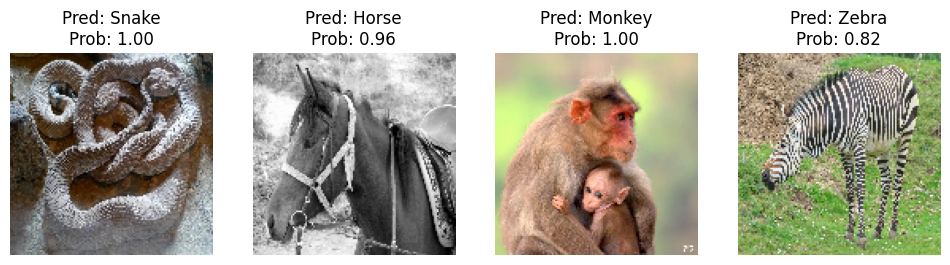

In [53]:
# Model Evaluation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_classes(model, img_paths, class_names, img_size=128):
    """Predict the class of images and return predictions, probabilities, and images."""
    predictions = []
    probabilities = []
    images = []
    
    for img_path in img_paths:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(img_size, img_size))  # Resize to target size
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize to [0, 1]
        
        # Predict the class probabilities
        pred = model.predict(img_array)
        
        # Get the predicted class index and probability
        pred_class_index = np.argmax(pred, axis=1)[0]
        pred_probability = np.max(pred)
        
        # Convert the class index to the class name
        predicted_class = class_names[pred_class_index]
        
        predictions.append(predicted_class)
        probabilities.append(pred_probability)
        images.append(img)
    
    return predictions, probabilities, images

def display_predictions(img_paths, predictions, probabilities, images):
    """Display the images with their predicted class and probability."""
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {predictions[i]}\nProb: {probabilities[i]:.2f}")
    plt.show()

# Example usage
img_paths = [
    r"D:\ML Project\Dataset\Snake\0ae2888ec25ba342.jpg",
    r"D:\ML Project\Dataset\Horse\0a8c7bbae99db4df.jpg",
    r"D:\ML Project\Dataset\Monkey\6b5dd31eb57262b4.jpg",
    r"D:\ML Project\Dataset\Zebra\510ef5a918394935.jpg"
]

# Assuming `model` and `class_names` are already defined
predictions, probabilities, images = predict_classes(loaded_model_vgg, img_paths, class_names)
display_predictions(img_paths, predictions, probabilities, images)


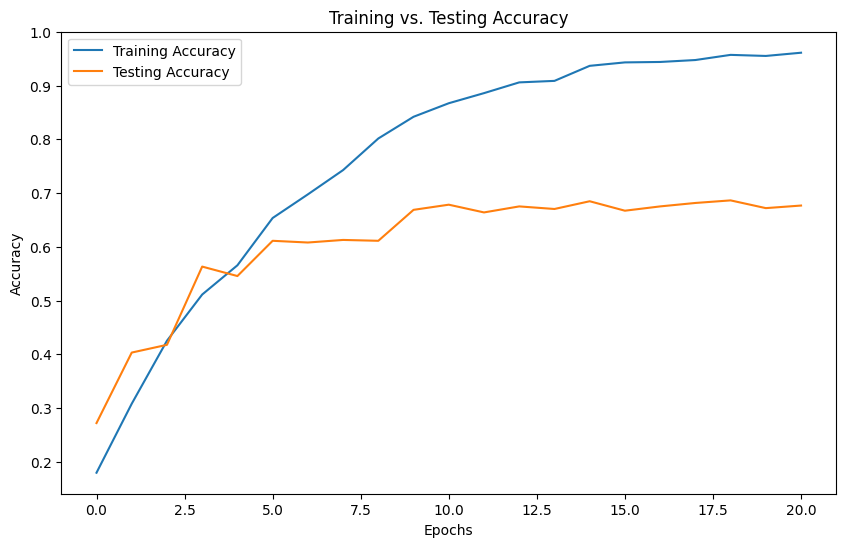

In [55]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    """Plots the training and validation accuracy over epochs."""
    epochs = range(len(history.history['accuracy']))
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

# Example usage:
plot_accuracy(history)


20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


<Figure size 1000x800 with 0 Axes>

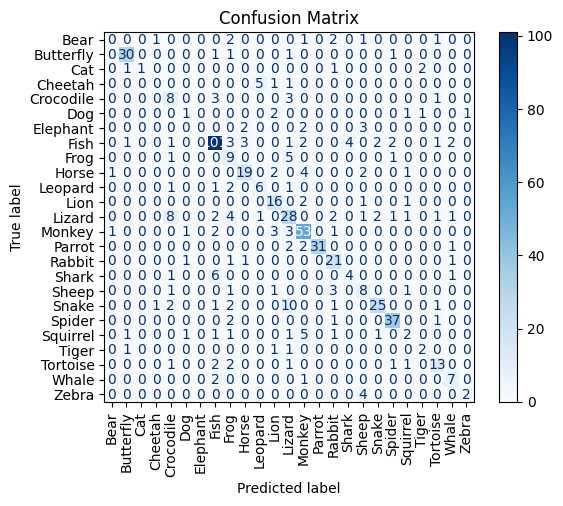

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_images, test_labels, class_names):
    """Plots the confusion matrix for the given model and test data."""
    # Predict the classes
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, predicted_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(loaded_model_vgg, test_images, test_labels, class_names)


In [23]:
import os
print(os.getcwd())


C:\Users\kesha


In [25]:
os.chdir(r"D:\ML Project")
print("Current directory:", os.getcwd())


Current directory: D:\ML Project


In [27]:
import pickle

# Save class names to a file
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)


In [29]:
import os

# Check if 'index.html' exists in the 'templates' folder
templates_path = os.path.join(os.getcwd(), 'templates', 'index.html')
if os.path.exists(templates_path):
    print(f"'index.html' is correctly placed at: {templates_path}")
else:
    print(f"'index.html' is missing in the expected location: {templates_path}")


'index.html' is correctly placed at: D:\ML Project\templates\index.html


In [ ]:
from flask import Flask, render_template, request, send_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import pickle

# Initialize the Flask app
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = './uploads'
app.config['ALLOWED_EXTENSIONS'] = {'jpg', 'jpeg'}

# Create uploads directory if it doesn't exist
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

# Load the saved model
model = load_model(r"D:\ML Project.keras")  # Replace with your saved model path

# Load class names from the preprocessing step
with open('class_names.pkl', 'rb') as f:
    class_names = pickle.load(f)

# Helper function to check allowed file extensions
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

# Helper function to predict image class
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    predictions = model.predict(img_array)
    class_index = np.argmax(predictions, axis=1)[0]
    class_name = class_names[class_index]
    probability = np.max(predictions)
    return class_name, probability

# Define the routes
@app.route('/', methods=['GET', 'POST'])
def index():
    predictions = []
    probabilities = []
    images = []

    if request.method == 'POST':
        files = request.files.getlist('file')  # Get multiple files
        for file in files:
            if file and allowed_file(file.filename):
                filename = file.filename
                file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
                file.save(file_path)

                # Predict the class
                class_name, probability = predict_image(file_path)
                predictions.append(class_name)
                probabilities.append(probability)
                images.append(filename)
            else:
                # If the file is not allowed, print a warning message
                print(f"Invalid file: {file.filename}")

        # Zip the lists together for passing to the template
        results = zip(images, predictions, probabilities)

        # Return the predictions for the uploaded images
        return render_template('index.html', results=results)

    return render_template('index.html')

@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

# Start the Flask app
if __name__ == '__main__':
    import os
    os.environ['FLASK_RUN_FROM_CLI'] = 'false'
    from werkzeug.serving import run_simple
    run_simple('localhost', 5000, app)


 * Running on http://localhost:5000
Press CTRL+C to quit
127.0.0.1 - - [19/Nov/2024 19:21:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2024 19:21:55] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


127.0.0.1 - - [19/Nov/2024 19:22:20] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2024 19:22:20] "GET /uploads/0df78ee76bafd3a9.jpg HTTP/1.1" 200 -
